# Capstone Project - Which Shoe is the Best for You?

General Assembly passion project. Scrape or obtain data from resources online to develop a dataset to perform cleaning, EDA, and analysis on. Try to predict a model on common themes like: 

- Price
- If item is in category A or B
- Cluster and create groups

- Predict lowest amount a shoe will sell for? So people know what price to wait for before buying?

---

### Tasks
1. Regression: Predict price (deadstock/retail) **OR** rarity of a shoe based on color, brand, desc, *reviews from Amazon?*, etc.
    - Feature Selection
    - Feature Extraction
    - Linear Regression
2. Classification: Predict if shoe will be a rare (hot) shoe? - So if a new shoe with similar features come out, would it be rare or not?
    - Logistic Regression
    - Do a more robust decision tree
3. Make a recommendation based on clusters

### Notes
- Describe what deadstock price means
- Maybe make construction material from category?
- Trends - black or white shoes more popular
- what is a good investment (category, color, etc.)? Return biggest bang for buck
- Look for sales and volume data

---

Have to use AWS

Narrative: I'm bad at noticing shoe brands. what is this?

Augment: cluster on visual properties on shoes

In [389]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from time import sleep, strftime
import ast
from os import listdir

pd.options.mode.chained_assignment = None

%matplotlib inline
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 9 ms


**Testing one website and finding appropriate keys**

Then run again on page 2.

In [2]:
# Retrieving information from API in json format
result = requests.get('https://stockx.com/api/browse?page=1&category=152')
json_res = result.json()
result = requests.get('https://stockx.com/api/browse?page=2&category=152')
json_res = result.json()
print json_res['Products'][0]['shortDescription']
print json_res['Products'][0]['retailPrice']

Air-Jordan-12-Retro-Black-Red-Flu-Game-2016
190
time: 29.8 s


In [3]:
# Valuable information in the market section
json_res['Products'][0]['market']

{u'absChangePercentage': 0.058824,
 u'annualHigh': 446,
 u'annualLow': 172,
 u'averageDeadstockPrice': 297,
 u'averageDeadstockPriceRank': 36,
 u'changePercentage': -0.058824,
 u'changeValue': -15,
 u'createdAt': u'2016-04-29T17:28:48+00:00',
 u'deadstockRangeHigh': 258,
 u'deadstockRangeLow': 222,
 u'deadstockSold': 4255,
 u'deadstockSoldRank': 81,
 u'highestBid': 250,
 u'lastHighestBidTime': 1499108766,
 u'lastLowestAskTime': 1499404609,
 u'lastSale': 240,
 u'lastSaleDate': u'2017-07-08T15:15:02+00:00',
 u'lowestAsk': 169,
 u'pricePremium': 0.263,
 u'pricePremiumRank': 31,
 u'productId': 0,
 u'productUuid': u'265eca11-aff7-4fb9-9501-30ed7100ecd6',
 u'salesLast72Hours': 32,
 u'salesLastPeriod': 0,
 u'salesThisPeriod': 32,
 u'skuUuid': None,
 u'updatedAt': 1499526910,
 u'volatility': 0.076081}

time: 6 ms


### Functions to run for loop to scrape website

First function scrapes the web for an amount of pages (default 50). It will save the raw data as a csv as well. The second function will then clean the dataframe by taking out the unused columns.

In [4]:
def shoe_scraper(pages=50):
    '''Returns one dataframe of all results. And will save into a new file.'''
    
    # Have to run requests first to get appropriate column names
    req = requests.get('https://stockx.com/api/browse?page=1&category=152')
    json_req = req.json()
    df = pd.DataFrame([], columns=json_req['Products'][0].keys())

    for i in range(1,pages):
        try:
            html = 'https://stockx.com/api/browse?page=' + str(int(i)) + '&category=152'
            result = requests.get(html)
            json_res = result.json()
            df = pd.concat([df, pd.DataFrame(json_res['Products'])])
            sleep(0.5)
        except:
            break
    
    # Drop row duplicates
    df.drop_duplicates(['shortDescription', 'urlKey'], inplace=True) 
    
    # Function to save as csv file under today's day as raw (before dropping)
    def csv_maker(df):
        filename = 'StockX_' + strftime("%m%d%H")
        df.to_csv(path_or_buf='C:\\Users\\Chris\\Desktop\\dsi-atl-3\\project\\Capstone\\datasets\\' + filename, encoding='utf-8')
    
    csv_maker(df)
    
    return df

time: 21 ms


In [247]:
def clean_df(busy_dataframe):
    '''Dropping columns that hold little to no information. Combining columns with relevant info.
    Then reset the index since we are getting repeated indices'''
    
    # Market DataFrame. If scraping, comes in ready form
    # If pulling from old data, dictionary comes in string form
    if isinstance(busy_dataframe.market.reset_index(drop=True)[0], str):
        market_df = pd.DataFrame([ast.literal_eval(row) for row in busy_dataframe['market']])
    else:
        market_df = pd.DataFrame([row for row in busy_dataframe['market']])
        
    # Same, but for including link for images
    if isinstance(busy_dataframe.media.reset_index(drop=True)[0], str):
        media_df = pd.DataFrame([ast.literal_eval(row) for row in busy_dataframe['media']])['thumbUrl']
    else:
        media_df = pd.DataFrame([row for row in busy_dataframe['media']])['imageUrl']
    
    # Combine dataframes and drop unnecessary columns
    cleaner_dataframe = busy_dataframe.join(market_df)
    cleaner_dataframe = cleaner_dataframe.join(media_df)
    
    cleanest_dataframe = cleaner_dataframe.drop(['breadcrumbs', 'childId', 'countryOfManufacture', 'type', 
        'uuid', 'dataType', 'doppelgangers', 'condition', 'description', 'hidden', 'ipoDate', 'productCategory', 
        'shoeSize', 'urlKey', 'charityCondition', 'releaseTime', 'shortDescription', 'media', '_highlightResult', 
        'market', '_tags', 'id', 'objectID', 'lastHighestBidTime', 'lastLowestAskTime', 'styleId', 'productId',
        'productUuid', 'skuUuid', 'updatedAt', 'traits', 'tickerSymbol', 'salesLastPeriod',
        'minimumBid', 'averageDeadstockPriceRank', 'deadstockSoldRank', 'pricePremium', 'pricePremiumRank',
        'salesThisPeriod', 'createdAt', 'lastSaleDate'], axis=1)
    
    # Reset the index, since we are getting repeated indices
    cleanest_dataframe.reset_index(drop=True, inplace=True)
    
    return cleanest_dataframe

time: 18 ms


### Run scrape on website
Use functions to read all previously saved csv files into one dataframe and do some preliminary cleaning. For now, only using the first duplicate. Trying to use last duplicate results in some weird prices, but are more up-to-date. **Try to figure out way to get most up-to-date observations.**

Finally, set up dataframe.

---

In [6]:
## Web Scraper code. Commented out so that no new information is gathered at the moment.
scraped_shoe = shoe_scraper()

time: 1min 3s


In [7]:
def read_and_clean(path):
    '''Read a file path where datasets are stored. Cleans the dataframe by removing duplicates,
    removing first column (Unnamed: 0) to be ready for clean_df function.'''
    file_list = listdir(path)
    file_list.remove('dataio')
    
    # Make a list of all the dataframes
    parts_df = [pd.read_csv('../datasets/' + files) for files in file_list]
    
    # Make one dataframe, take out first column and drop duplicates based on 'urlkey'
    df = pd.concat(parts_df)
    df = df.iloc[:,1:]
    df.drop_duplicates(['uuid'], inplace=True)#, keep='last')
    
    # Clean Brand names
    df.brand = df.brand.map(lambda x: x.title())
    
    # Lastly, change 'nan' to np.nan.
    df = df.applymap(lambda x: np.nan if x=='nan' else x)

    return df

time: 10 ms


In [248]:
path = '../datasets/'

shoe = clean_df(read_and_clean(path))

time: 2.46 s


### Dataframe is set
Some initial cleaning and EDA will need to be done.
- Drop nulls
- Change time series into datetime if possible
- Check out the shape
- Drop the error value for the high bid > $20,000

**Make a metric for rarity: average Deadstock Price / retail Price**

In [249]:
# Some cleaning first. Take out null rows and change time data to date time
shoe.dropna(inplace=True)
shoe['releaseDate'] = pd.to_datetime(shoe.releaseDate).dt.date
shoe['year'] = shoe.year.map(lambda x: int(x))
shoe.shape

(1968, 24)

time: 21 ms


In [250]:
# New metric for rarity of shoe & a boolean for those above median
shoe['rarity'] = shoe.averageDeadstockPrice/shoe.retailPrice
shoe['rarity_bool'] = shoe.rarity.map(lambda x: 1 if x >= shoe.rarity.median() else 0)

# Since shoes retailed at $0 doesn't fit into the scope of the project, drop them.
infinity_ind = shoe[shoe.retailPrice==0].index
shoe.drop(infinity_ind, axis=0, inplace=True)
shoe.reset_index(inplace=True, drop=True)

# Most 'rare' shoes
shoe[['title', 'year', 'retailPrice', 'averageDeadstockPrice', 'highestBid', 'rarity', 'rarity_bool']].sort_values('rarity', ascending=False).head()

,title,year,retailPrice,averageDeadstockPrice,highestBid,rarity,rarity_bool
1683,Nike Dunk SB Low Supreme NY Black Cement (2002),2002,65.0,1388,1000,21.353846,1
1799,Nike SB Dunk High Momofuku,2017,110.0,1706,1336,15.509091,1
1600,Jordan 1 Retro Low OG Ice Blue,2017,140.0,1936,3037,13.828571,1
1800,Air Max 1 Air Max Day 3.26,2014,125.0,1706,1336,13.648000,1
1293,Nike Dunk SB High Tie Dye Black,2014,108.0,1447,1000,13.398148,1


time: 273 ms


(-5, 1500)

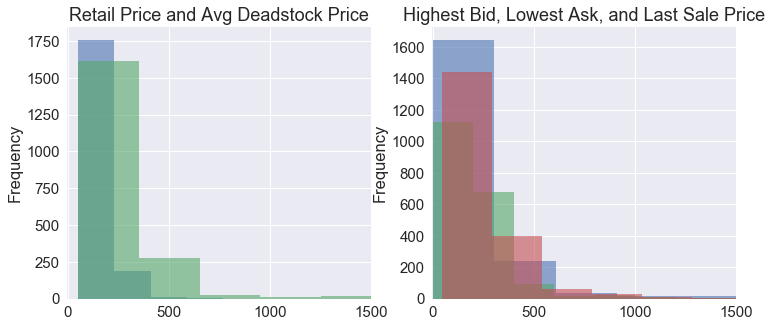

time: 496 ms


In [251]:
# Plots for general overview
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

shoe.retailPrice.plot(kind='hist', alpha=0.6, ax=ax1)
shoe.averageDeadstockPrice.plot(kind='hist', alpha=0.6, ax=ax1)
ax1.set_title('Retail Price and Avg Deadstock Price')
ax1.axes.set_xlim(-5, 1500)

shoe.highestBid.plot(kind='hist', alpha=0.6, ax=ax2)
shoe.lowestAsk.plot(kind='hist',alpha=0.6, ax=ax2)
shoe.lastSale.plot(kind='hist', alpha=0.6, ax=ax2)
ax2.set_title('Highest Bid, Lowest Ask, and Last Sale Price')
ax2.axes.set_xlim(-5,1500)

In [252]:
# A view of the most expensive bid on shoe.
shoe[shoe.highestBid > 2000][['shoe', 'colorway', 'lastSale', 'highestBid', 'averageDeadstockPrice', 'retailPrice']].sort_values('highestBid', ascending=False)

,shoe,colorway,lastSale,highestBid,averageDeadstockPrice,retailPrice
1598,Adidas Ultra Boost,Adidas-Ultra-Boost-Miami-Hurricanes,2515,3037,1936,180.0
1599,Nike Air Max 90,White/White,2515,3037,1936,160.0
1600,Jordan 1 Retro Low OG,Ice Blue/Vachetta Tan-White,2515,3037,1936,140.0
374,Jordan 1 Retro,Black/Sport Blue-White,1605,3000,1696,185.0
625,Adidas Yeezy Boost 750,Brown/Carbon White-Light Brown,2500,2125,3059,350.0
259,Adidas Yeezy Boost 350,Turtledove/Blue Grey-White,2100,2050,2223,200.0
352,Adidas NMD,EQT Yellow/EQT Yellow/FTWR White,2001,2050,828,240.0


time: 25 ms


In [253]:
# A view at the most highest retailed shoe. Strangely enough, it is not in the top 7 highest bid.
shoe[shoe.retailPrice == shoe.retailPrice.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year']]

,shoe,colorway,name,retailPrice,year
1642,Air Yeezy 2,Gold/White,John Geiger x LASCO Golden Child,1850.0,2016


time: 19 ms


In [254]:
# A look at the highest average deadstock price
shoe[shoe.averageDeadstockPrice == shoe.averageDeadstockPrice.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year', 'averageDeadstockPrice']]

,shoe,colorway,name,retailPrice,year,averageDeadstockPrice
625,Adidas Yeezy Boost 750,Brown/Carbon White-Light Brown,OG Light Brown,350.0,2015,3059


time: 15 ms


In [255]:
# A look at the highest last sale price
shoe[shoe.lastSale == shoe.lastSale.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year', 'lastSale']]

,shoe,colorway,name,retailPrice,year,lastSale
1598,Adidas Ultra Boost,Adidas-Ultra-Boost-Miami-Hurricanes,Miami Hurricanes,180.0,2016,2515
1599,Nike Air Max 90,White/White,Laser NYC,160.0,2016,2515
1600,Jordan 1 Retro Low OG,Ice Blue/Vachetta Tan-White,Ice Blue,140.0,2017,2515


time: 14 ms


In [256]:
shoe.describe()

,retailPrice,year,absChangePercentage,annualHigh,annualLow,averageDeadstockPrice,changePercentage,changeValue,deadstockRangeHigh,deadstockRangeLow,deadstockSold,highestBid,lastSale,lowestAsk,salesLast72Hours,volatility,rarity,rarity_bool
count,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000
mean,173.545038,2014.755216,0.205430,443.346056,168.981170,281.164377,0.003748,-11.504326,305.448346,207.135878,222.023410,222.201018,256.274809,230.898728,5.172010,0.201120,1.729700,0.499237
std,75.700467,3.028989,0.233005,487.207703,134.388534,224.803635,0.310645,102.970774,268.931775,181.072808,434.578408,240.316178,222.178677,193.340978,22.620056,0.135812,1.445367,0.500127
min,50.000000,1985.000000,0.000000,50.000000,11.000000,50.000000,-0.666667,-1058.000000,55.000000,-18.000000,1.000000,0.000000,45.000000,0.000000,1.000000,0.000000,0.135135,0.000000
25%,140.000000,2014.000000,0.041860,250.000000,100.000000,174.000000,-0.157895,-41.000000,176.000000,110.000000,21.000000,110.000000,149.000000,140.000000,1.000000,0.123416,1.051429,0.000000
50%,160.000000,2016.000000,0.136986,325.000000,140.000000,228.000000,0.000000,0.000000,238.000000,167.000000,77.000000,176.000000,200.000000,185.000000,2.000000,0.177207,1.392857,0.000000
75%,190.000000,2017.000000,0.302222,471.000000,195.000000,313.000000,0.106667,21.000000,350.000000,246.000000,233.000000,250.000000,300.000000,250.000000,4.000000,0.251232,1.891892,1.000000
max,1850.000000,2017.000000,2.529412,8550.000000,1715.000000,3059.000000,2.529412,549.000000,3693.000000,1900.000000,5579.000000,3037.000000,2515.000000,2000.000000,916.000000,1.362362,21.353846,1.000000


time: 72 ms


### Descriptions of some columns

- deadstockRangeHigh = highest price of deadstock within the last 12 mo.
- deadstockRangeLow = lowest price of deadstock within the last 12 mo.
- highestBid = highest price someone is bidding, or willing to pay
- lowestAsk = lowest price someone is currently asking for, or selling
- rarity = averageDeadstockPrice / retailPrice
- lastSale = Last price product was sold for sourced from ebay, twitter, etc.
---
### Make a dataframe with only the top brands: Nike, Jordan, Adidas
Scale the dataframe down so that not too many outside brands are taking the focus away from the main goal of the project.

---

In [257]:
shoe.brand.value_counts()[:5]

Nike      728
Jordan    639
Adidas    459
Asics      40
Vans       25
Name: brand, dtype: int64

time: 7 ms


In [258]:
# Concerned with only the top brands
tops = shoe[(shoe.brand=='Adidas')|(shoe.brand=='Nike')|(shoe.brand=='Jordan')]
tops.reset_index(drop=True, inplace=True)

time: 9 ms


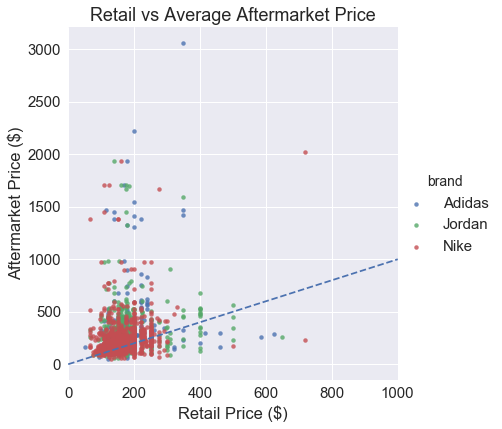

time: 308 ms


In [259]:
# See a 1-to-1 linear line for retail Price vs Aftermarket price
sns.set(font_scale=1.5)
sns.lmplot(x='retailPrice', y ='averageDeadstockPrice', data=tops, hue='brand', fit_reg=False, size=6,
          scatter_kws={"s": 20})
plt.plot(np.linspace(0,2000,2000), np.linspace(0,2000,2000), linestyle='--')
plt.xlim([0,1000])
plt.title('Retail vs Average Aftermarket Price')
plt.xlabel('Retail Price ($)')
plt.ylabel('Aftermarket Price ($)')
plt.show()

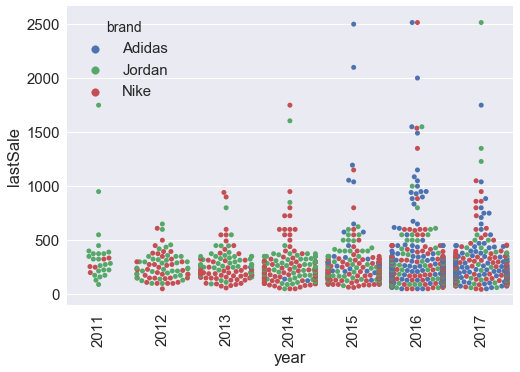

time: 29.6 s


In [21]:
sns.swarmplot(x='year', y='lastSale', data=tops[tops.year>2010], hue='brand')
plt.xticks(rotation=90)
plt.show()

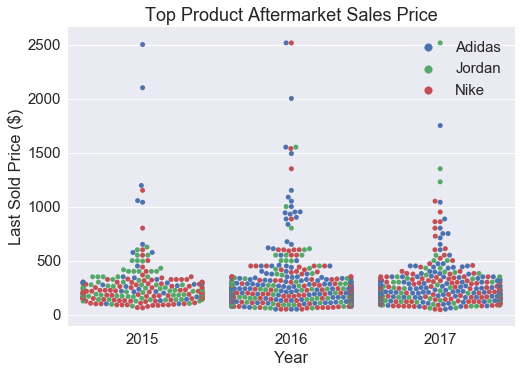

time: 31.5 s


In [22]:
# Adidas didn't really come into the market until 2015. Let's look more closely
sns.swarmplot(x='year', y='lastSale', data=tops[tops.year>2014], hue='brand')
plt.legend(loc='best')
plt.xlabel('Year')
plt.ylabel('Last Sold Price ($)')
plt.title('Top Product Aftermarket Sales Price')
plt.show()

### After some market research, Adidas came into the sneakerhead culture because of two products: the Adidas Boost and the Adidas Yeezy's

Nike was first partnered with Kanye West for making a collaborative shoe. But after his contract ended, Mr. West changed sides to Adidas, who previously was widely known for their athletic shoes (for soccer and football) rather than collectible sneakers.

---

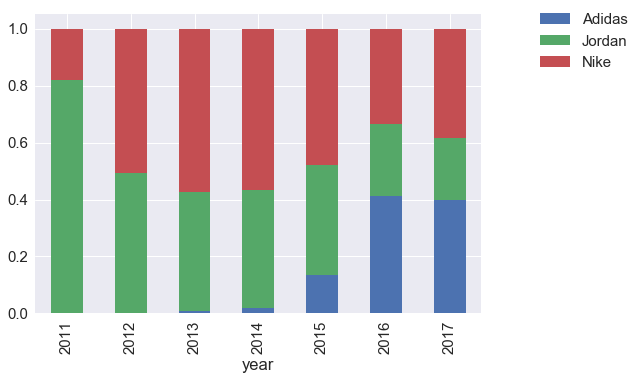

brand,Adidas,Jordan,Nike
year,,,
2011,0.000000,0.821429,0.178571
2012,0.000000,0.493151,0.506849
2013,0.009259,0.416667,0.574074
2014,0.017341,0.416185,0.566474
2015,0.134454,0.386555,0.478992
2016,0.411972,0.253521,0.334507
2017,0.397059,0.218487,0.384454


time: 266 ms


In [23]:
# Did Adidas increase market share (on StockX)?
sub_tops = tops[tops.year>2010].groupby(['year', 'brand'])['brand'].count().unstack().fillna(0)
sub_tops = sub_tops.T
sub_tops = sub_tops.div(sub_tops.sum())
sub_tops = sub_tops.T

sub_tops.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()
sub_tops

# Analysis time:


In [260]:
# Import libraries
# NLP
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer

# Metrics & Preprocessing
from sklearn.metrics import accuracy_score, completeness_score, silhouette_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

time: 7 ms


In [261]:
# Function for looking at heat maps
def heat(indexed_df, use_annot=True):
    # Set init variables
    corr = indexed_df.corr()
    # Set the default matplotlib figure size to 7x7:
    fix, ax = plt.subplots(figsize=(12,7))
    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corr, mask=mask, annot=use_annot, annot_kws={"size":13}, ax=ax)
    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation='vertical')
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

time: 10 ms


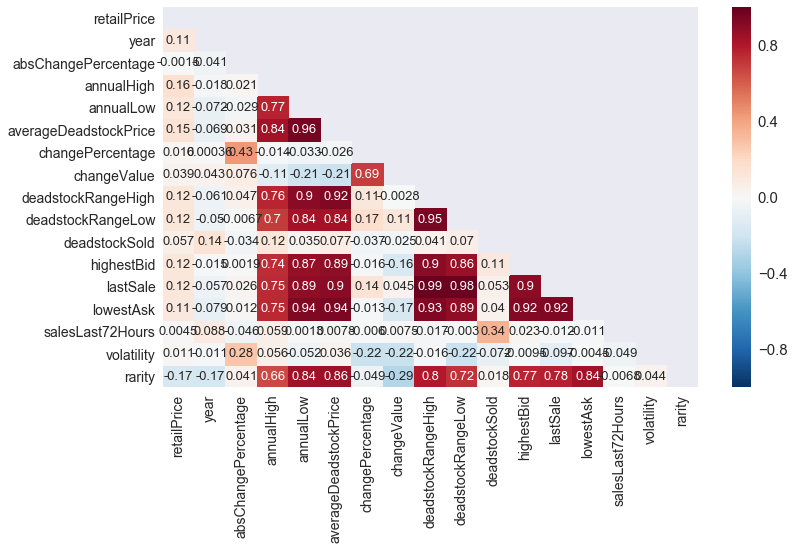

time: 770 ms


In [262]:
heat(tops.loc[:,:'rarity'], True)

In [263]:
# Maybe the colorway is an indicator of averageDeadstockPrice
snow = SnowballStemmer('english')

# placeholder = pd.Series('Colorway_token')
placeholder = pd.Series(tops.colorway.apply(lambda x: x.replace("/"," ").replace('-',' ').split(" ")))

tops['colorway_token'] = placeholder.apply(lambda x: " ".join([snow.stem(y) for y in x]))

time: 259 ms


In [264]:
baseline = max(1 - tops.rarity_bool.mean(), tops.rarity_bool.mean())
print baseline

0.506571741512
time: 4 ms


In [265]:
# Make X, y, and train/test split
X = tops.drop('rarity_bool', axis=1)
y = tops.rarity_bool
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)

time: 13 ms


In [266]:
# Going to try several vectorizers and models. Better to write a function that will do this in one step.
def tokenize_test(text, vect, model, target='rarity_bool', 
                  X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    '''Arguments are text, vect, model, target (in strings), X_train, X_test, y_train, y_test.
    Used to find the accuracy of the rarity.'''
    X = tops[text]
    y = tops[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)
    X_train_dtm = vect.fit_transform(X_train)
    
    X_test_dtm = vect.transform(X_test)
    model.fit(X_train_dtm, y_train)
    y_pred_class = model.predict(X_test_dtm)
    return accuracy_score(y_test, y_pred_class)

# Making a function to make a dataframe for the accuracy results of tokenize_test
def accuracy_df_maker(models, vectors, texts, target):
    '''models and vectors are dictionarys with key as the label and value as the object.
    texts is a list of features to test on. Returns a sorted dataframe with accuracy scores
    of every model, vectorizer, and feature combintion'''
    Accuracy_scores = []
    for model_k, model_v in models.items():
        for vect_k, vect_v in vectors.items():
            for text in texts:
                Accuracy_scores.append((model_k, vect_k, text, tokenize_test(text, vect_v, model_v, target)))
    
    df = pd.DataFrame(Accuracy_scores, columns=['Model', 'Vectorizer', 'Feature', 'Accuracy_score'])
    return df.sort_values('Accuracy_score', ascending=False).reset_index(drop=True)

time: 25 ms


In [267]:
# Parameter set up
ng = (2,5)
cvec, hvec, tvec = CountVectorizer(ngram_range=ng), HashingVectorizer(ngram_range=ng), TfidfVectorizer(ngram_range=ng)

models = {'SVC':SVC(), 'Log':LogisticRegression(), 'Bernoulli':BernoulliNB(), 'KNN':KNeighborsClassifier()}
vectors = {'CVEC':cvec, 'HVEC':hvec, 'TVEC': tvec}
texts = ['colorway_token', 'category', 'title', 'name']

# Function run
nlp = accuracy_df_maker(models, vectors, texts, 'rarity_bool')
print 'Baseline: ', baseline
nlp.head()

Baseline:  0.506571741512


,Model,Vectorizer,Feature,Accuracy_score
0,Log,HVEC,category,0.581967
1,KNN,HVEC,category,0.579235
2,Log,CVEC,title,0.579235
3,Bernoulli,TVEC,category,0.579235
4,Bernoulli,CVEC,category,0.573770


time: 5.49 s


In [268]:
# Separate functions because random forest with hashing takes more than 3 minutes with worse results.
# Same with Multinomial. Combining all into one dataframe, nlp_df

models2 = {'Random Forest':RandomForestClassifier(), 'Multinomial':MultinomialNB()}
vectors2 = {'CVEC':cvec, 'TVEC':tvec}

nlp_add = accuracy_df_maker(models2, vectors2, texts, target='rarity_bool')
nlp_df = pd.concat([nlp, nlp_add]).sort_values('Accuracy_score', ascending=False).reset_index(drop=True).copy()

time: 2.75 s


In [269]:
# Trying bagging and boosting. Again hashing takes too long and doesn't increase score by much. So taking out.

# Model Set up
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
bagger = BaggingClassifier(dtree, max_samples=0.5, max_features=0.5)
booster = AdaBoostClassifier(dtree, n_estimators=50, learning_rate=1.0)

# Parameter setup
models3 = {'Bagger':bagger, 'Booster':booster}

bag_add = accuracy_df_maker(models3, vectors2, texts, target='rarity_bool')
df = pd.concat([nlp_df, bag_add]).sort_values('Accuracy_score', ascending=False).reset_index(drop=True).copy()

time: 41.1 s


In [270]:
print 'Baseline: ', baseline
df[df.Accuracy_score > baseline*1.175]

Baseline:  0.506571741512


,Model,Vectorizer,Feature,Accuracy_score
0,Booster,TVEC,category,0.598361
1,Multinomial,CVEC,title,0.595628


time: 14 ms


In [462]:
# Trying to finetune models to achieve better accuracy scores
from sklearn.model_selection import GridSearchCV
X = tops.title
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)

X_train_dtm = tvec.fit_transform(X_train)
X_test_dtm = tvec.transform(X_test)

log_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}
lr_gridsearch = GridSearchCV(LogisticRegression(), log_params, cv=5, verbose=1)
lr_gridsearch.fit(X_train_dtm, y_train)
lr_dict = lr_gridsearch.best_params_
print lr_dict

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'penalty': 'l2', 'C': 0.55908101825122225, 'solver': 'liblinear'}
time: 6.87 s


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.6s finished


In [272]:
logreg = LogisticRegression(C=lr_dict['C'], penalty=lr_dict['penalty'], solver=lr_dict['solver'])
logreg.fit(X_train_dtm, y_train)
print accuracy_score(y_test, logreg.predict(X_test_dtm)), df.iloc[0,-1]

0.584699453552 0.598360655738
time: 9 ms


In [273]:
# Trying to do PCA on these word vectors to achieve better score:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)
svd_words = svd.fit_transform(X_train_dtm)

logreg.fit(svd_words, y_train)
svd_pred_df = pd.DataFrame(logreg.predict(svd.transform(X_test_dtm)))

print accuracy_score(y_test, svd_pred_df.iloc[:,:6])
print 'Due to randomness, results show values from 0.55 to 0.62, which would be nearly the best model'

0.573770491803
Due to randomness, results show values from 0.55 to 0.62, which would be nearly the best model
time: 207 ms


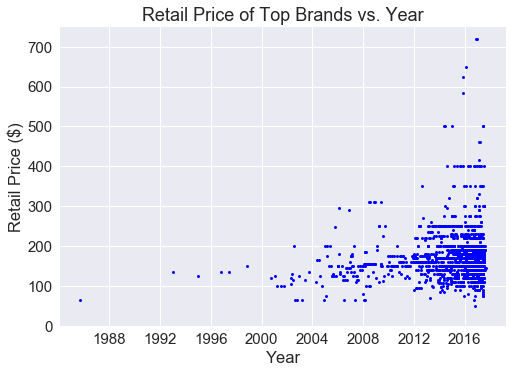

time: 196 ms


In [274]:
# Try doing times series of release date vs. retailprice/averageDeadstockPrice
cops = tops.set_index('releaseDate').sort_index()

plt.plot(cops.retailPrice, 'bo', markersize=3)
# plt.plot(cops.averageDeadstockPrice, 'r*', markersize=3)
plt.xlabel('Year')
plt.ylabel('Retail Price ($)')
plt.title('Retail Price of Top Brands vs. Year')
plt.ylim(0,750);

## Clustering

To get the most out of clustering, more features will have to be converted into numbers.

In [275]:
cv_color = CountVectorizer(max_features=20, stop_words=['core'], ngram_range=(1,2))
all_colors = cv_color.fit_transform(tops.colorway_token)
color_df = pd.DataFrame(all_colors.todense(), columns=cv_color.get_feature_names())
color_df.sum()[:5]

black          1250
black black     177
black white     161
blue            271
dark            105
dtype: int64

time: 65 ms


In [288]:
#### Dummy variables ####
# Change brand to 0, 1, 2
# Change category based on words [Yeezy, NMD, Air Jordan, Ultra Boost, Adidas/Nike Other, 
# Air Max, Iniki, Air Force, Foamposite, LeBron, KD, Nike SB, Kobe, Nike Basketball/Other]
# Change colorway based on color spectrum colors (color_df.columns)

tops.brand = tops.brand.astype('category').cat.codes

category_list = ['Yeezy', 'NMD', 'Air Jordan', 'Ultra Boost', 'adidas Other', 'Nike Other', 'Air Max',
                'Iniki', 'Air Force', 'Foamposite', 'LeBron', 'KD', 'Nike SB', 'Kobe', 'Nike Basketball']
for cat in category_list:
    tops[cat] = tops.category.map(lambda x: 1 if cat.lower() in x.lower() else 0)
    
color_list = list(color_df.columns)    
for color in color_list:
    tops[color] = tops.colorway_token.map(lambda x: 1 if color.lower() in x.lower() else 0)

time: 80 ms


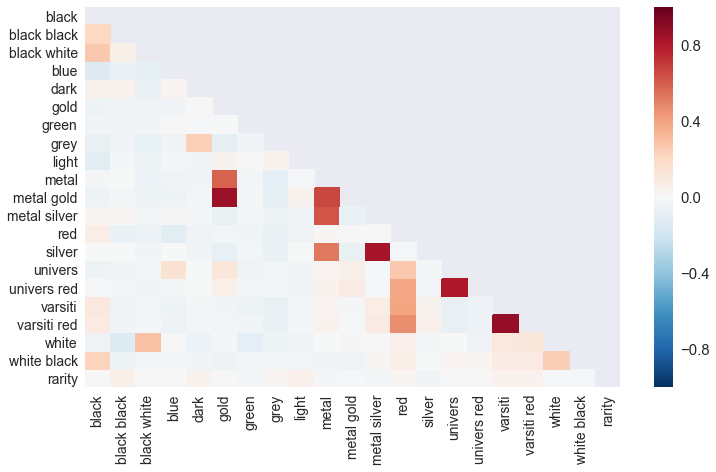

time: 377 ms


In [277]:
rare_and_color = color_list
rare_and_color.append('rarity')
heat(tops.loc[:,rare_and_color], False)

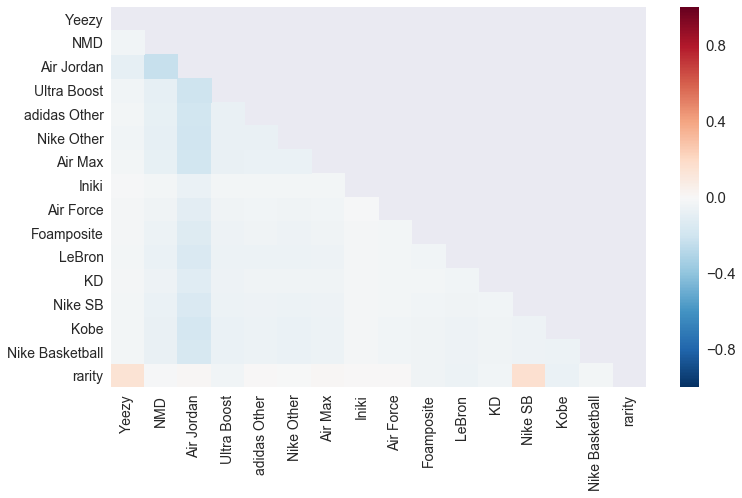

time: 343 ms


In [278]:
rare_and_cat = category_list
rare_and_cat.append('rarity')
heat(tops.loc[:,rare_and_cat],False)

In [279]:
import patsy

matrix_string = '''
category ~ 
retailPrice + absChangePercentage + annualHigh + annualLow + averageDeadstockPrice +
deadstockRangeHigh + deadstockRangeLow + brand +
deadstockSold + highestBid + lastSale + lowestAsk + salesLast72Hours + volatility +
rarity
'''

y_cluster, X_cluster = patsy.dmatrices(matrix_string, tops)

time: 52 ms


In [280]:
from sklearn.cluster import DBSCAN, KMeans
ss = StandardScaler()
Xs = ss.fit_transform(X_cluster)

db = DBSCAN(eps=1.5, min_samples=5)
db.fit(Xs)

print pd.Series(db.labels_).unique()
print 'Not in a class %:', list(db.labels_).count(-1)/float(len(tops)) * 100
print 'In first class %:', list(db.labels_).count(0)/float(len(tops)) * 100
print 'In remaining classes %:', 100 - (list(db.labels_).count(-1)/float(len(tops)) * 100 + list(db.labels_).count(0)/float(len(tops)) * 100)
print '------------------------'
print 'Last label count:', list(db.labels_).count(pd.Series(db.labels_).unique()[-1])

tops['cluster_label'] = pd.Series(db.labels_)

[-1  2  0  1  3]
Not in a class %: 12.3767798467
In first class %: 21.0843373494
In remaining classes %: 66.5388828039
------------------------
Last label count: 8
time: 269 ms


In [281]:
# KMeans
km = KMeans(n_clusters=5)
km.fit(Xs)
pd.Series(km.labels_).unique()

print pd.Series(km.labels_).value_counts()

tops['cluster_label'] = pd.Series(km.labels_)

2    1008
0     515
1     216
4      53
3      34
dtype: int64
time: 99 ms


In [282]:
tops[tops.cluster_label == 4]

,brand,category,colorway,name,releaseDate,retailPrice,shoe,title,year,absChangePercentage,...,metal silver,red,silver,univers,univers red,varsiti,varsiti red,white,white black,cluster_label
0,Adidas,adidas Yeezy,Core White/Core White/Core White,Calabasas Core White,2017-03-28,120.0,Adidas Yeezy Powerphase,Adidas Yeezy Powerphase Calabasas Core White,2017,0.093750,...,0,0,0,0,0,0,0,1,0,4
1,Adidas,adidas NMD,Core Black/Core Black/Footwear White,OG Black,2017-05-20,150.0,Adidas NMD XR1,Adidas NMD XR1 OG Black,2017,0.086957,...,0,0,0,0,0,0,0,1,0,4
4,Jordan,Air Jordan One,Black/Varsity Maize-White,New Love (2017),2017-06-01,110.0,Jordan 1 Retro Mid,Jordan 1 Retro Mid New Love (2017),2017,0.084906,...,0,0,0,0,0,1,0,1,0,4
5,Jordan,Air Jordan Thirteen,Black/Anthracite-Black,Black Cat,2017-01-21,190.0,Jordan 13 Retro,Jordan 13 Retro Black Cat,2017,0.029412,...,0,0,0,0,0,0,0,0,0,4
6,Adidas,adidas Ultra Boost,White/Core Black,Oreo,2017-02-01,180.0,Adidas Ultra Boost 3.0,Adidas Ultra Boost 3.0 Oreo,2017,0.104545,...,0,0,0,0,0,0,0,1,0,4
8,Jordan,Air Jordan Four,Black/Metallic Gold-White,Royalty,2017-02-04,190.0,Jordan 4 Retro,Jordan 4 Retro Royalty,2017,0.176471,...,0,0,0,0,0,0,0,1,0,4
10,Jordan,Air Jordan One,Black/Black-Metallic Gold,Wings,2017-05-17,200.0,Jordan 1 Retro High,Jordan 1 Retro High Wings,2017,0.048583,...,0,0,0,0,0,0,0,0,0,4
11,Jordan,Air Jordan Three,White/True Blue-Varsity Red,True Blue (2016),2016-11-25,220.0,Jordan 3 Retro,Jordan 3 Retro True Blue (2016),2016,0.222222,...,0,1,0,0,0,1,1,1,0,4
12,Adidas,adidas NMD,Core Black/Core Black/Lush Red,Core Black Lush Red (2015/2017),2015-12-12,170.0,Adidas NMD R1,Adidas NMD R1 Core Black Lush Red (2015/2017),2015,0.238095,...,0,1,0,0,0,0,0,0,0,4
13,Nike,Air Max Other,Metallic Silver/Varsity Red-Black-White,Silver Bullet (2016/2017),2016-12-14,170.0,Air Max 97,Air Max 97 Silver Bullet (2016/2017),2016,0.059113,...,1,1,1,0,0,1,1,1,0,4


time: 119 ms


In [638]:
# Now have a bunch more variables. Would be a good idea to do PCA on the features to avoid multicollinearity.
num_df = tops.drop(['cluster_label','retailPrice', 'averageDeadstockPrice', 'releaseDate', 'category', 'colorway', 
                    'name', 'shoe', 'title', 'thumbUrl', 'colorway_token'], axis=1).copy()

# Make another dataframe that doesn't include any colors or names to see if all those dummy variable creation mattered.
no_extra_df = num_df.loc[:,:'rarity_bool'].copy()

time: 7 ms


In [625]:
def model_maker(X, y, N_components, model=LinearRegression()):
    '''Prints out cross-val score of training data and R^2 score of test data.
    Can use PCA dependent on N_components and choose either linear or logistic regression.'''
    # Model input set up
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state=42)
    Xs = ss.fit_transform(X_train)
    Xst = ss.transform(X_test)
    
    # Using PCA
    if N_components > 0:
        pca = PCA(n_components=N_components)
        pca_train = pca.fit_transform(Xs)
        # For linear or logistic regression (two labels only)
        if len(y.unique()) >= 2:
            train_score = np.mean(cross_val_score(model, pca_train, y_train, cv=5))
            print 'Cross-val score on training:', train_score
            model.fit(pca_train, y_train)
            pca_test = pd.DataFrame(pca.transform(Xst))
            test_score = model.score(pca_test,y_test)
            print 'R^2 (RSS) on test:', test_score
        else:
            print 'Choose a target that is either boolean or for linear regression'
    # Not using PCA
    elif N_components == 0 or N_components == None:
        if len(y.unique()) >= 2:
            train_score = np.mean(cross_val_score(model, Xs, y_train, cv=5))
            print 'Cross-val score on training:', train_score
            model.fit(Xs, y_train)
            test_score = model.score(Xst, y_test)
            print 'R^2 (RSS) on test:', test_score
        else:
            print 'Choose a target that is either boolean or for linear regression'
    # Catch for weird inputs
    else:
        print 'Choose a correct N_components'

    return train_score, test_score

time: 20 ms


In [630]:
# PCA for linear regression
X = no_extra_df.drop(['rarity', 'rarity_bool'], axis=1)
y = num_df.rarity
model_maker(X,y,6,linreg)

Cross-val score on training: 0.687954264185
R^2 (RSS) on test: 0.794662207962


(0.68795426418506778, 0.79466220796227482)

time: 36 ms


In [632]:
# PCA for classification
X = no_extra_df.drop(['rarity', 'rarity_bool'], axis=1)
y = num_df.rarity_bool
model_maker(X,y,2,logreg)

Cross-val score on training: 0.793865138309
R^2 (RSS) on test: 0.806010928962


(0.79386513830936312, 0.80601092896174864)

time: 49 ms


In [633]:
# Non-PCA logistic regression
X = no_extra_df.drop(['rarity', 'rarity_bool'], axis=1)
y = num_df.rarity_bool
model_maker(X,y,0,logreg)

Cross-val score on training: 0.802781048614
R^2 (RSS) on test: 0.814207650273


(0.80278104861364485, 0.81420765027322406)

time: 60 ms


In [587]:
coef_df = pd.DataFrame(zip(no_extra_df.drop(['rarity','rarity_bool'],axis=1).columns, logreg.coef_[0]), columns=['Feature', 'Coefficients'])
coef_df['abs'] = abs(coef_df.Coefficients).copy()
coef_df = coef_df.sort_values('abs', ascending=False).reset_index(drop=True)
coef_df.head(7)

,Feature,Coefficients,abs
0,brand,0.167128,0.167128
1,absChangePercentage,0.148954,0.148954
2,lastSale,0.121365,0.121365
3,changePercentage,0.120464,0.120464
4,deadstockRangeLow,-0.061488,0.061488
5,deadstockRangeHigh,-0.050289,0.050289
6,volatility,0.024141,0.024141


time: 17 ms


In [636]:
# Using only the top 7 coefficients as features
X = tops.loc[:,coef_df.loc[:7,'Feature']]
y = num_df.rarity
model_maker(X,y,0,linreg)

Cross-val score on training: 0.654815627818
R^2 (RSS) on test: 0.811905273935


(0.65481562781831903, 0.81190527393462841)

time: 30 ms


## Image Processing using Keras

The code below is for image processing using Keras and Tensorflow. Unfortunately, these libraries don't play nicely with Windows. As a result, a virtual machine was used in another notebook. The forked repository is an extension of the deep learning repository by github user *[nirmalyaghosh](https://github.com/nirmalyaghosh/deep-learning-vm)*.

Imaging code adapted from *[source1](https://pythonprogramming.net/automated-image-thresholding-python/?completed=/thresholding-python-function/)* and *[source2](http://pillow.readthedocs.io/en/3.4.x/reference/Image.html)*. Finally, pickling code was sourced from *[stackoverflow](https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict)*.

The code to transfer data is below in markdown mode for reading convenience. The rest of the code can be found at *[my github](https://github.com/chrisk447/deep-learning-vm/blob/master/notebooks/Capstone%20Image%20Processing.ipynb)*.

    # only gathering images for those that have images. (As of 7/7/2017)
    tops_with_pics = tops[tops.thumbUrl != '']
    tops_with_pics.reset_index(drop=True, inplace=True)

    import urllib3
    from PIL import Image
    import io

    pickled_array = []
    counter = 0
    for shoe_num in range(len(tops_with_pics)):
        fd =urllib.urlopen(tops_with_pics.thumbUrl[shoe_num])
        image_file = io.BytesIO(fd.read())
        i = Image.open(image_file).convert('RGB')
        iar = np.asarray(i)
        iar.setflags(write=1)

        pickled_array.append(iar)
        if counter % 200 == 0:
            print shoe_num
        counter += 1
        sleep(0.5)
        image_file.close()
        fd.close()

    # import pickle
    with open('../../../keras/deep-learning-vm/notebooks/shoenumbers.pickle', 'wb') as handle:
        pickle.dump(pickled_array, handle, protocol=2)

    # Saving target variables to use in Keras VM
    with open('../../../keras/deep-learning-vm/notebooks/targetvars.pickle', 'wb') as handle2:
        pickle.dump(tops_with_pics.rarity_bool.values, handle2, protocol=2)